# Importing Libraries

in this part we will install all the necessary libraries on command prompt and then import the necessary functions from those libraries. 

In [1]:
# importing all the necessary libraries

import pandas as pd



from numpy import mean

import numpy as np

import time



# step 1: preprocessing

from sklearn.impute import SimpleImputer # import some strategic imputer to fill in any missing values using mean

from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, Normalizer # scale all the values to one range to avoid any biasness (this bias is seen in mostly naive bayes and knn etc)



from sklearn.impute import KNNImputer # import some strategic imputer to fill missing values using KNN (finds the nearest neighbour and fills it with that value)



from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_classif, VarianceThreshold

from sklearn.feature_selection import f_regression

from sklearn.decomposition import PCA

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge, Lasso



# step 2: data division

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV, ParameterGrid # to divide the code into train/test using a specific percentage or with/without replacement



# step 3: model

from xgboost import XGBRegressor



# step 4: displaying accuracy

from sklearn.metrics import roc_auc_score, accuracy_score # to display the accuracy of our tree

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer



# step 5: warning filter

import warnings

warnings.filterwarnings('ignore')

In [2]:
from datetime import datetime



# Function to get current date and time as a string

def get_current_datetime():

    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Data Loading

data shall be loaded into variables as data sets using pandas and csv readers. they will be checked to see if they are loaded properly and will be loaded as 2 sets: train and test as per given in the kaggle data

In [3]:
# lets load the training data set

# train_data = pd.read_csv(r"D:\Users\DELL\OneDrive - Institute of Business Administration\IBA\sem5\machine learning\ipynb notebooks\challenger2\iml-fall-2024-challenge-2\train\train.csv")

train_data = pd.read_csv(r"/kaggle/input/challenge2/train.csv")

# lets also check it by getting the first few rows of the data, there should be x1 - x78 and one target variable Y

train_data.head() 

,full_sq,life_sq,floor,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,43.0,27.0,4.0,Investment,Bibirevo,6407578.100,155572.0,0.189727,0.000070,9576.0,...,9.0,4.0,0.0,13.0,22.0,1.0,0.0,52.0,4.0,5850000.0
1,34.0,19.0,3.0,Investment,Nagatinskij Zaton,9589336.912,115352.0,0.372602,0.049637,6880.0,...,15.0,3.0,0.0,15.0,29.0,1.0,10.0,66.0,14.0,6000000.0
2,43.0,29.0,2.0,Investment,Tekstil'shhiki,4808269.831,101708.0,0.112560,0.118537,5879.0,...,10.0,3.0,0.0,11.0,27.0,0.0,4.0,67.0,10.0,5700000.0
3,77.0,77.0,4.0,Investment,Basmannoe,8398460.622,108171.0,0.015234,0.037316,5706.0,...,319.0,108.0,17.0,135.0,236.0,2.0,91.0,195.0,14.0,16331452.0
4,67.0,46.0,14.0,Investment,Nizhegorodskoe,7506452.020,43795.0,0.007670,0.486246,2418.0,...,62.0,14.0,1.0,53.0,78.0,1.0,20.0,113.0,17.0,9100000.0


In [4]:
# lets load the test data

# test_data = pd.read_csv(r"D:\Users\DELL\OneDrive - Institute of Business Administration\IBA\sem5\machine learning\ipynb notebooks\challenger2\iml-fall-2024-challenge-2\test\test.csv")

test_data = pd.read_csv(r"/kaggle/input/challenge2/test.csv")

# check if the data has been loaded by getting the first 5 rows - there should be x1 - x78 and no target variable Y as this is test data

test_data.head() 

,row ID,full_sq,life_sq,floor,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,Row3,89.0,50.0,9.0,Investment,Mitino,1.258354e+07,178473.0,0.194703,0.069753,...,15.0,11.0,2.0,1.0,4.0,4.0,0.0,0.0,26.0,3.0
1,Row6,25.0,14.0,10.0,Investment,Sokol'niki,1.032047e+07,57405.0,0.523439,0.042307,...,144.0,81.0,16.0,3.0,38.0,80.0,1.0,27.0,127.0,8.0
2,Row11,38.0,19.0,11.0,Investment,Zapadnoe Degunino,7.632940e+06,78810.0,0.051844,0.437885,...,39.0,8.0,3.0,0.0,10.0,9.0,0.0,0.0,35.0,4.0
3,Row12,43.0,28.0,4.0,Investment,Kuncevo,5.235177e+07,142462.0,0.070662,0.035145,...,21.0,13.0,9.0,1.0,7.0,15.0,0.0,2.0,47.0,0.0
4,Row14,31.0,21.0,3.0,Investment,Lefortovo,8.993640e+06,89971.0,0.066941,0.306977,...,205.0,88.0,19.0,2.0,63.0,100.0,0.0,28.0,132.0,14.0


# Data Preprocessing

before we start processing this data and using algorithms, we will fix this data first, this is called data preprocessing

## split data into categorical and numerical

categorical will have one-hot and simple imputer of most frequent while numerical will have simple mean imputer and minmax scaler

In [5]:
categorical_cols = train_data.select_dtypes(include=["object"]).columns

numerical_cols = train_data.select_dtypes(exclude=["object"]).drop(columns=['price_doc']).columns

In [6]:
# num_transformer = Pipeline(steps=[

#     ("imputer", SimpleImputer(strategy="mean")),

#     ("scaler", StandardScaler())

# ])



# cat_transformer = Pipeline(steps=[

#     ("imputer", SimpleImputer(strategy="most_frequent")),

#     ("onehot", OneHotEncoder(handle_unknown="ignore"))

# ])

In [7]:
# # Column transformer for preprocessing

# preprocessor = ColumnTransformer(

#     transformers=[

#         ("num", num_transformer, numerical_cols),

#         ("cat", cat_transformer, categorical_cols)

#     ]

# )

# imputer

In [8]:
num_imputer = SimpleImputer(strategy="mean")

train_data[numerical_cols] = num_imputer.fit_transform(train_data[numerical_cols])

test_data[numerical_cols] = num_imputer.transform(test_data[numerical_cols])



cat_imputer = SimpleImputer(strategy="most_frequent")

train_data[categorical_cols] = cat_imputer.fit_transform(train_data[categorical_cols])

test_data[categorical_cols] = cat_imputer.transform(test_data[categorical_cols])

# scaler

In [9]:
scaler = StandardScaler()

train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])

test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

# onehot

In [10]:
train_data = pd.get_dummies(train_data, columns=categorical_cols, drop_first=True)

test_data = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)

# Align the test data with the training data columns

test_data = test_data.reindex(columns=train_data.columns, fill_value=0)



# test_data = test_data.drop(columns=['price_doc'], errors="ignore")

## correlation matrix

i tried getting the correlation matrix but apparently a 2000 columns matrix is very computationally expensive as it performs pairs for all. so dont run it. it takes too long and then fails. i ran for 5 minutes. 

In [11]:
# # DONT RUN

# corr_matrix = train_data.corr()

# print(corr_matrix)

# variance

In [12]:
train_features = train_data.drop(columns=['price_doc'])

In [13]:
feature_variances = train_features.var(axis=0)

print(feature_variances.describe())

count    2199.000000
mean        0.117869
std         0.320496
min         0.000011
25%         0.000055
50%         0.000083
75%         0.000160
max         1.000006
dtype: float64


In [14]:
from sklearn.feature_selection import VarianceThreshold



selector = VarianceThreshold(threshold=0.001) 

train_features_reduced = selector.fit_transform(train_features)

print(train_features_reduced)

print(train_features_reduced.shape)



# test_features = selector.transform(test_data)

[[-0.36470882 -0.37522428 -0.51514242 ...  0.          0.
   0.        ]
 [-0.37280689 -0.3805375  -0.58285457 ...  0.          0.
   0.        ]
 [-0.36470882 -0.37389597 -0.65056671 ...  0.          1.
   0.        ]
 ...
 [-0.36020989 -0.37123936 -0.58285457 ...  1.          0.
   0.        ]
 [-0.36020989 -0.37123936 -0.58285457 ...  1.          0.
   0.        ]
 [-0.36020989 -0.37123936 -0.58285457 ...  1.          0.
   0.        ]]
(181507, 419)


# PCA

principal component analysis is applied

Cumulative explained variance:  [0.39231335 0.514862   0.5802623  0.59705995 0.61214279 0.62431943
 0.63542231 0.64591917 0.65359847 0.6605143  0.66659745 0.67241833
 0.67769868 0.68275051 0.68752819 0.69181166 0.69594857 0.69982132
 0.70348352 0.70709045 0.71038222 0.71361313 0.71673894 0.71977858
 0.72255733 0.72530354 0.72801424 0.73066475 0.73320958 0.73570549
 0.73811025 0.74046763 0.74281316 0.74507277 0.74728903 0.7494008
 0.75148565 0.75354523 0.75558949 0.75759671 0.7595836  0.76150954
 0.76342184 0.76530501 0.7671628  0.76898938 0.77081455 0.77261839
 0.7743995  0.7761368  0.77786032 0.77954768 0.78121928 0.78287298
 0.78448667 0.78607626 0.78765151 0.78920526 0.79074869 0.79224554
 0.79373673 0.79521097 0.79666755 0.79812019 0.79954703 0.80095278
 0.80235415 0.80373155 0.80507634 0.80641603 0.80774361 0.80905395
 0.81036119 0.8116663  0.81295308 0.81423609 0.81551449 0.81678689
 0.81804515 0.81929955 0.82054686 0.82178517 0.82301996 0.8242491
 0.82547682 0.82669639 0.8279133

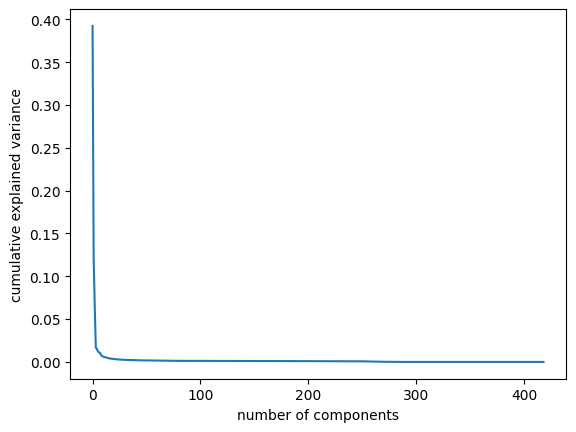

In [15]:
# plot an elbow graph to find the optimal number of components

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA



pca = PCA()

pca.fit(train_features_reduced)  # Fit PCA to your dataset



plt.plot(pca.explained_variance_ratio_)

plt.xlabel('number of components')

plt.ylabel('cumulative explained variance')

pca.explained_variance_ratio_.round(3)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

print("Cumulative explained variance: ", cumulative_variance)

print(cumulative_variance)

In [16]:
print("Principal components shape:", pca.components_.shape)

print("Principal components:\n", pca.components_)



# Preserve the target variable

train_copy = train_data.copy()  # Backup original data

test_copy = test_data.copy()



# Separate target variable and features

train_features = train_data.drop(columns=['price_doc'])  # Features for PCA

train_target = train_data['price_doc']                  # Target variable



test_features = test_data.drop(columns=['price_doc'])    # Features for PCA



# Apply PCA transformation

pca = PCA(n_components=0.95)

train_features_pca = pca.fit_transform(train_features)  # Fit and transform train data

print("train transformed")

test_features_pca = pca.transform(test_features)        # Transform test data



print(train_features_pca.shape)

print(test_features_pca.shape)

Principal components shape: (419, 419)
Principal components:
 [[ 7.88654496e-02  7.23794804e-02  7.03805488e-02 ... -7.91886110e-05
  -5.19344279e-03  1.43522191e-03]
 [ 1.47683465e-02  1.96512267e-02  8.13583967e-03 ...  5.09077331e-02
  -2.53633127e-02 -4.77159484e-03]
 [-3.39532130e-02 -2.88231291e-02 -3.60368274e-02 ...  1.76935881e-02
   6.78393023e-03 -1.44607478e-02]
 ...
 [-5.89355310e-04 -1.41911872e-04 -2.48641483e-04 ...  6.51448449e-03
  -3.72454647e-03 -2.67858597e-04]
 [ 2.23162797e-04  1.53748518e-04  2.97484169e-04 ... -8.13601183e-03
   8.49906030e-04  1.42968835e-03]
 [ 5.38181789e-04  2.46076673e-04  2.70487779e-04 ... -3.87893519e-05
   8.18282587e-04  5.88437486e-04]]
train transformed
(181507, 205)
(77789, 205)


In [17]:
# Reconstruct train_data and test_data with PCA-transformed features and target variable

train_data = pd.DataFrame(train_features_pca)

train_data['price_doc'] = train_target.reset_index(drop=True)



test_data = pd.DataFrame(test_features_pca)

test_data['price_doc'] = test_copy['price_doc'].reset_index(drop=True)

In [18]:
print("train shape: ", train_data.shape)

print("test shape: ", test_data.shape)

train shape:  (181507, 206)
test shape:  (77789, 206)


## Data Splitting - festures and targets

the data in train_data set is of x1 - x78 columns (79 variables) and one target variable (Y). we must split that data so that we can perform data preprocessing on the features variables (will be referred to as X).

In [19]:
# so in X, it is ALL the columns EXCEPT the last column known as 'Y' (we can confirm this using the train_data.head() we did earlier) so we must get all columns and DROP only the 'y' column

X = train_data.drop(columns=['price_doc'])

X # lets display X and see what it is now

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
0,-4.312322,-4.182745,-5.485081,-1.126028,-2.710338,-0.141229,-0.955874,0.243185,-2.993960,-0.314327,...,-0.091567,0.151993,-0.084652,-0.010834,0.065580,-0.118517,0.136505,0.002964,0.068504,0.093171
1,-5.313539,-3.236283,-2.802348,0.491519,-1.340977,-0.330479,-0.199231,0.132354,0.701082,-0.010571,...,-0.063258,-0.024367,-0.012832,-0.045062,-0.009366,-0.055498,-0.021882,0.064875,0.126848,0.164984
2,-6.184591,-2.855476,-1.935236,1.691816,-0.679154,0.370659,-0.473277,-0.440100,3.058773,-0.290442,...,-0.138204,-0.092982,-0.081218,0.058792,-0.090635,0.065780,-0.058621,-0.036531,0.089105,0.115456
3,7.694079,-11.714296,7.366454,-4.165054,-0.464963,2.812168,-2.122877,-0.962343,0.382899,0.650936,...,0.165010,-0.166023,0.251680,-0.004303,-0.460468,0.221307,-0.235361,-0.035771,-0.013944,0.107902
4,-4.521644,-3.766634,3.967774,6.734243,-1.738590,1.569467,-0.925501,1.536060,0.783250,-2.303188,...,-0.047100,0.091411,-0.073608,0.007875,0.025588,-0.086392,-0.019812,-0.280706,-0.037847,-0.029940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181502,-0.481318,18.049028,1.658240,-3.402723,-1.237623,-0.830496,2.527415,1.817104,1.414072,1.751664,...,-0.004141,-0.070273,0.058333,-0.057640,0.064966,0.026179,-0.060749,-0.031882,0.113453,0.014453
181503,-0.481318,18.049028,1.658240,-3.402723,-1.237623,-0.830496,2.527415,1.817104,1.414072,1.751664,...,-0.004141,-0.070273,0.058333,-0.057640,0.064966,0.026179,-0.060749,-0.031882,0.113453,0.014453
181504,-0.481318,18.049028,1.658240,-3.402723,-1.237623,-0.830496,2.527415,1.817104,1.414072,1.751664,...,-0.004141,-0.070273,0.058333,-0.057640,0.064966,0.026179,-0.060749,-0.031882,0.113453,0.014453
181505,-0.481318,18.049028,1.658240,-3.402723,-1.237623,-0.830496,2.527415,1.817104,1.414072,1.751664,...,-0.004141,-0.070273,0.058333,-0.057640,0.064966,0.026179,-0.060749,-0.031882,0.113453,0.014453


In [20]:
# so as per our X output, we can see that number of columns in train_data is 79 and number of columns in X is 78 meaning we have successfully performed our removal of target variable

# now to get the target variable alone, we can just get it alone,

Y = train_data['price_doc']

Y # lets see what it is

# as per our Y output, we can see it is of one column and 246k rows which means we have successfully extracted the target variable column

0          5850000.0
1          6000000.0
2          5700000.0
3         16331452.0
4          9100000.0
             ...    
181502     3480000.0
181503     3480000.0
181504     3480000.0
181505     3480000.0
181506     3480000.0
Name: price_doc, Length: 181507, dtype: float64

# Filters

there are two types of filters to filter out columns/features:

- variance filter (a column which has same values throughout the column like all are sunny)

- correlation filter (two columns which are same like weight in kg and weight in pounds)

In [21]:
# print("X : ", X.shape)

# print("test data : ", test_data_processed.shape)

In [22]:
# variance filter

# ----------------------------- case  -----------------------------

# variance_filter = VarianceThreshold(threshold=0.001)  # Adjust the threshold if needed

# X = variance_filter.fit_transform(X)

# test_data_processed = variance_filter.fit_transform(test_data_processed)

X.shape

(181507, 205)

In [23]:
# test_data_processed.shape

In [24]:
# # correlation filter

# # ----------------------------- case  -----------------------------

# corr_matrix = pd.DataFrame(X).corr().abs()

# upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# X = pd.DataFrame(X).drop(columns=to_drop)

# test_data_processed = pd.DataFrame(test_data_processed).drop(columns=to_drop)

X.shape

(181507, 205)

In [25]:
# test_data_processed.shape

## Data Splitting - train and validate

now our test_data set is of rows with NO target variable whereas the train_data set is WITH target variable.

our rules in machine learning is that we must train half or 70% of the data and then we must check its accuracy using the remaining half or 30% of the data - we can only check accuracy IF we have the answers i.e. the target variable. 

So, what we need to do is, is split the train_data set into 2, by a 70% and 30% ratio. we train the model using the 70% and then test the model using the 30% and then use that model to predict the test_data set.

In [26]:
# holdout method

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

# functions

here we have defined functions like forward-backward selection, kbest selection & algorithm feature importance

In [27]:
class VerboseSequentialFeatureSelector(SequentialFeatureSelector):

    def fit(self, X, y):

        print("Starting feature selection...")

        selected_features = []

        for i in range(1, self.n_features_to_select + 1):

            print(f"Selecting feature {i}/{self.n_features_to_select}")

            super().fit(X, y)

            selected_features = self.get_support(indices=True)

            print(f"Features selected so far: {selected_features}")

        return self

In [28]:
# forward backward selection



def fbselection(direction, sample_model, features, sample_X, sample_Y, X, trainX, trainY, testX, test_data_processed):

    print("starting")

    selection = VerboseSequentialFeatureSelector(sample_model, direction=direction, n_features_to_select=features, scoring='r2', n_jobs=-1)

    return modelSelector(sample_model, selection, sample_X, sample_Y, X, trainX, trainY, testX, test_data_processed)



def modelSelector(sample_model, selection, sample_X, sample_Y, X, trainX, trainY, testX, test_data_processed):



    print("start extracting")



    sample_X = selection.fit_transform(sample_X, sample_Y)



    print("extracted, transforming")



    trainX = selection.transform(trainX)



    testX = selection.transform(testX)                                  # Ensure the test set is transformed similarly



    test_data_processed = selection.transform(test_data_processed)      # test data is also transformed



    X = selection.transform(X)                                          # full data transforming



    print("transformed")



    return sample_model, X, trainX, trainY, testX, test_data_processed







# kbest selection



def kbest(sample_model, features, sample_X, sample_Y, X, trainX, trainY, testX, test_data_processed):



    print("starting")



    selection = SelectKBest(score_func=f_classif, k=features)



    return modelSelector(sample_model, selection, sample_X, sample_Y,X, trainX, trainY, testX, test_data_processed)

In [29]:
# feature importance function

def featureImportance(sample_model, features, X, trainX, trainY, testX, test_data_processed):

    print("fitting")

    

    # fit the model

    sample_model.fit(trainX, trainY)



    print("extracting features")



    # extract all the feature names from data

    importances = sample_model.feature_importances_

    feature_names = train_data.drop(columns=['price_doc']).columns

    print(feature_names)



    # sort with respect to importance

    feature_importance_df = pd.DataFrame({

        'Feature': feature_names,

        'Importance': importances

    }).sort_values(by='Importance', ascending=False)



    # extract the top ones

    top_features = feature_importance_df['Feature'].head(features).values

    print(top_features)



    # change all data according to the top ones we have selected

    trainX = pd.DataFrame(trainX, columns=feature_names)[top_features]

    testX = pd.DataFrame(testX, columns=feature_names)[top_features]

    X = pd.DataFrame(X, columns=feature_names)[top_features]

    test_data_processed = pd.DataFrame(test_data_processed, columns=feature_names)[top_features]



    print("features extracted")

    

    # retrain the model

    sample_model.fit(trainX, trainY)



    print("features trained")

    

    return sample_model, X, trainX, trainY, testX, test_data_processed

## model intialization

here model is intialized

In [30]:
# trainX = preprocessor.fit_transform(trainX)

# print("trainX completed")

# testX = preprocessor.transform(testX)

# print("testX completed")

# test_data = preprocessor.transform(test_data)

# print("test data completed")

# X = preprocessor.transform(X)

# print(X.shape)

In [31]:
# declare the model here

model = XGBRegressor(max_depth=10, learning_rate=0.01, n_estimators=1600, subsample=0.85, reg_lambda=0.2, reg_alpha=0.8)

In [32]:
print("X shape -> ", X.shape)

print("trainX shape -> ", trainX.shape)

print("testX shape -> ", testX.shape)

print("test_data_processed shape -> ", test_data.shape)

X shape ->  (181507, 205)
trainX shape ->  (145205, 205)
testX shape ->  (36302, 205)
test_data_processed shape ->  (77789, 206)


# feature selection

here we will apply feature selection and feature importance

In [33]:
# sample_train = train_data.sample(frac=0.1)

# sample_X = sample_train.drop(columns=['price_doc'])

# sample_Y = sample_train['price_doc']

# print(sample_X)

# print(sample_X.shape)

# print(sample_Y.shape)

In [34]:
# sample_X = preprocessor.transform(sample_X)

In [35]:
# # Feature selection

# model, X, trainX, trainY, testX, test_data = fbselection(

#     "forward", model, 100, sample_X, sample_Y, X, trainX, trainY, testX, test_data

# )

In [36]:
print("X shape -> ", X.shape)

print("trainX shape -> ", trainX.shape)

print("testX shape -> ", testX.shape)

print("test_data_processed shape -> ", test_data.shape)

X shape ->  (181507, 205)
trainX shape ->  (145205, 205)
testX shape ->  (36302, 205)
test_data_processed shape ->  (77789, 206)


# grid search

In [37]:
def gridsearch(param_grid, model, scorer, trainX, trainY):

    print("starting grid search")



    # intialize grid search

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=scorer, verbose=3)

    print("grid search is intialized")



    # fit the model

    grid_search.fit(trainX, trainY)

    print("grid search fitting completed")



    # display the best model grid search found

    best_model = grid_search.best_estimator_

    print(best_model)



    # display the best parameters of the best model

    best_parameters = grid_search.best_params_

    print(best_parameters)



    # display the best score of the best model

    print("Best cross-validated score:", grid_search.best_score_)



    # assign the best model our model

    model = best_model

    print("model assigned, grid search completed")



    return model

In [38]:
# # Define a scoring metric (e.g., negative mean squared error)

# scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [39]:
# # define hyper parameters of grid

# param_grid = {

#     'estimators': [10, 100, 200, 500, 1000, 2000, 3000], 

#     'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5],

#     'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# }

In [40]:
# sample from train_data

# sample_train = train_data.sample(frac=0.5)

# sample_X = sample_train.drop('price_doc', axis=1) 

# sample_Y = sample_train['price_doc']

In [41]:
# model = gridsearch(param_grid, model, scorer, trainX, trainY)

## model running

here we run the model

In [42]:
from datetime import datetime



def get_current_datetime():

    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

In [43]:
# compute this predictions metrics

def metrics(y_pred, testY):

    print("starting to compute metrics")

    

    # display the mean squared error of this prediction

    mse = mean_squared_error(testY, y_pred)

    print("Mean squared error: %.2f" % mse, "   ")



    # display the root mean squared error

    rmse = np.sqrt(mse)  # Root Mean Squared Error

    print("Root Mean squared error: %.2f" % rmse, "   ")



    # display the mean absolute error of this prediction

    mae = mean_absolute_error(testY, y_pred)

    print("Mean absolute error: %.2f" % mae, "   ")



    # display the coeffeicient of determination of this preduction

    r2_Score = r2_score(testY, y_pred)

    print("Coefficient of determination: %.2f" % r2_Score, "    ")

    

    return rmse

In [44]:
def run_model(model, trainX, trainY, testX, testY):

    print("evalset running ", get_current_datetime())
    
    # Define validation set
    eval_set = [(trainX, trainY), (testX, testY)]

    # Train the model with progress monitoring
    model.fit(
        trainX, trainY,
        eval_set=eval_set,         # Evaluation set for progress updates
        verbose=True,
        early_stopping_rounds=10
    )

    print("training model", get_current_datetime())

    # model.fit(trainX, trainY)

    print("computing score", get_current_datetime())

    print("model score: ", model.score(trainX, trainY), get_current_datetime())

    y_pred = model.predict(testX)

    rmse = metrics(y_pred, testY)

    return model, rmse

In [45]:
def createFile(model, X, Y, test_data, file_name):

    print("evalset running ", get_current_datetime())
    
    # Define validation set
    eval_set = [(X, Y), (testX, testY)]

    # Train the model with progress monitoring
    model.fit(
        X, Y,
        eval_set=eval_set,         # Evaluation set for progress updates
        verbose=True,
        early_stopping_rounds=10
    )



    print("scoring on X Y ", get_current_datetime())

    score = model.score(X, Y)

    print("model test score: ", score, "    ")

    print("predicting on test ", get_current_datetime())

    test_prediction = model.predict(test_data.drop(columns=['price_doc']))

    print(test_prediction)



    print("getting sample submission ", get_current_datetime())

    # sample_data = pd.read_csv(r"D:\Users\DELL\OneDrive - Institute of Business Administration\IBA\sem5\machine learning\ipynb notebooks\challenger2\iml-fall-2024-challenge-2\sample_submission.csv")

    sample_data = pd.read_csv(r"/kaggle/input/challenge2/sample_submission.csv")
    
    sample_data['price_doc'] = test_prediction



    print("Saving submission ", get_current_datetime())

    # Ensure the path ends with a backslash

    # base_path = r"D:\Users\DELL\OneDrive - Institute of Business Administration\IBA\sem5\machine learning\ipynb notebooks\challenger2\iml-fall-2024-challenge-2\\"

    base_path = r"/kaggle/working/"
    
    full_path = base_path + file_name

    sample_data.to_csv(full_path, index=False)

    print(f"File saved at: {full_path}")

In [46]:
def create_submission(model, trainX, trainY, testX, testY, X, Y, test_data, file_name):

    model, rmse = run_model(model, trainX, trainY, testX, testY)

    createFile(model, X, Y, test_data, file_name)

In [47]:
model = XGBRegressor(
    max_depth=13,               # Control tree depth
    learning_rate=0.009,         # Step size
    n_estimators=1400,          # Number of boosting rounds
    subsample=0.8,              # Fraction of training data to grow trees
    colsample_bytree=0.7,       # Fraction of features for each tree
    reg_lambda=0.2,               # L2 regularization
    reg_alpha=0.8,                # L1 regularization
    # device = 'cuda',
    verbose = 2,
    tree_method='hist',        # Use histogram-based optimization
    predictor='auto'           # Choose best predictor
)

model, rmse = run_model(model, trainX, trainY, testX, testY)

createFile(model, X, Y, test_data, "xgb1.csv")

# create_submission(model, trainX, trainY, testX, testY, X, Y, test_data, "xgb1.csv")

evalset running  2024-12-01 20:01:09
[0]	validation_0-rmse:21660005.44169	validation_1-rmse:21821241.66491
[1]	validation_0-rmse:21517730.28136	validation_1-rmse:21694766.57309
[2]	validation_0-rmse:21377028.55027	validation_1-rmse:21572447.80869
[3]	validation_0-rmse:21235415.59846	validation_1-rmse:21455184.80421
[4]	validation_0-rmse:21101360.42580	validation_1-rmse:21335631.75019
[5]	validation_0-rmse:20965775.15066	validation_1-rmse:21216366.43305
[6]	validation_0-rmse:20828029.72498	validation_1-rmse:21100625.05658
[7]	validation_0-rmse:20690444.95635	validation_1-rmse:20983558.92390
[8]	validation_0-rmse:20556349.99814	validation_1-rmse:20869172.00111
[9]	validation_0-rmse:20425504.13379	validation_1-rmse:20760879.58035
[10]	validation_0-rmse:20292985.61464	validation_1-rmse:20647718.96695
[11]	validation_0-rmse:20165796.49010	validation_1-rmse:20540367.95600
[12]	validation_0-rmse:20038546.40234	validation_1-rmse:20430829.81876
[13]	validation_0-rmse:19914162.60137	validation_1

In [48]:
print(X.shape)

(181507, 205)


In [49]:
# model = XGBRegressor(max_depth=10, learning_rate=0.01, n_estimators=1600, subsample=0.85, reg_lambda=0.2, reg_alpha=0.8)

# create_submission(model, trainX, trainY, testX, testY, X, Y, test_data, "xgb1.cxv")

In [50]:
# model = XGBRegressor(max_depth=10, learning_rate=0.001, n_estimators=1600, subsample=0.85, reg_lambda=0.2, reg_alpha=0.8)

# create_submission(model, trainX, trainY, testX, testY, X, Y, test_data, "xgb2.cxv")

In [51]:
# model = XGBRegressor(max_depth=10, learning_rate=0.01, n_estimators=1700, subsample=0.85, reg_lambda=0.2, reg_alpha=0.8)

# create_submission(model, trainX, trainY, testX, testY, X, Y, test_data, "xgb3.cxv")

In [52]:
# model = XGBRegressor(max_depth=11, learning_rate=0.01, n_estimators=1600, subsample=0.85, reg_lambda=0.2, reg_alpha=0.8)

# create_submission(model, trainX, trainY, testX, testY, X, Y, test_data, "xgb4.cxv")

## predict for test dataset

fit the model and predict for test dataset

In [53]:
# model.fit(X, Y)

In [54]:
# # display information regarding the regression

# print("model score: ", model.score(X, Y), "    ")

# # print("model coefficient: ", model.coef_)

# # print("model intercept: ", model.intercept_)

In [55]:
# test_prediction = model.predict(test_data)



# # test_prediction=test_prediction[:, 1]



# print(test_prediction)

## write into csv

now we write the predictions into the csv file

In [56]:
# sample_data = pd.read_csv(r"D:\Users\DELL\OneDrive - Institute of Business Administration\IBA\sem5\machine learning\ipynb notebooks\challenger2\iml-fall-2024-challenge-2\sample_submission.csv")



# sample_data['price_doc'] = test_prediction

# sample_data



# sample_data.to_csv(r"D:\Users\DELL\OneDrive - Institute of Business Administration\IBA\sem5\machine learning\ipynb notebooks\challenger2\iml-fall-2024-challenge-2\xgb1.csv", index=False)

# sample_data

In [57]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.009, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1400, n_jobs=None,
             num_parallel_tree=None, predictor='auto', ...)